# Basic H&E Workflow

In this notebook, we will use `PathML` to create a simple preprocessing pipeline for whole-slide H&E images. The pipeline will consist of a few parts:

1. Load image from disk
2. Tissue detection
2. Tiling tissue regions
4. Stain normalization on tile-level

We will make the pipeline by defining four classes: 

* `SlideLoader`: loads the slide from .svs file
* `SlidePreprocessor`: performs all slide-level preprocessing (i.e. tissue detection)
* `TileExtractor`: extracts tiles
* `TilePreprocessor`: performs all tile-level preprocessing (i.e. stain normalization)

Each class must implement an `apply()` method, which is then used to chain them together into a full-fledged preprocessing pipeline. 

We will define each part of the pipeline and demonstrate how it works, then at the end we will run the pipeline end-to-end on a full-resolution WSI.

In [1]:
import matplotlib.pyplot as plt
import os
import random
random.seed(45678)

from pathml.preprocessing.pipeline import Pipeline
from pathml.preprocessing.base_preprocessor import BaseSlideLoader, BaseSlidePreprocessor, BaseTilePreprocessor
from pathml.preprocessing.tiling import SimpleTileExtractor
from pathml.preprocessing.transforms_HandE import TissueDetectionHE
from pathml.preprocessing.stains import StainNormalizationHE
from pathml.preprocessing.wsi import HESlide
from pathml.preprocessing.utils import plot_mask, plot_extracted_tiles, label_whitespace_HE

## OpenSlide Data

This example notebook uses publicly available images from OpenSlide. Download them [here](http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/) if you want to run this notebook locally, or change the filepaths to any whole-slide images that you have locally.

In [2]:
example_image_path = "../data/CMU-1.svs"

## Define slide loader

The first step is to load the slide from disk. `pathml` provides utilities to make this easy, so it will only take a few lines of code to create our `SlideLoader` class for loading H&E stained .svs files:

In [3]:
class MySlideLoader(BaseSlideLoader):
    def apply(self, path):
        return HESlide(path).load_data()

In [4]:
data = MySlideLoader().apply(example_image_path)

## Define custom slide preprocessor

To make our own slide-level preprocessor, we create a class that inherits from `BaseSlidePreprocessor` and define the `apply()` method to perform basic tissue detection:

In [5]:
class MySlidePreprocessor(BaseSlidePreprocessor):
    """Our custom slide-level preprocessor which detects regions of tissue"""
    def apply(self, data):
        tissue_mask = TissueDetectionHE().apply(data.image) # apply tissue detection
        data.mask = tissue_mask # put the mask from tissue detection into the data object
        return data

Let's try it out:

In [6]:
data = MySlidePreprocessor().apply(data)

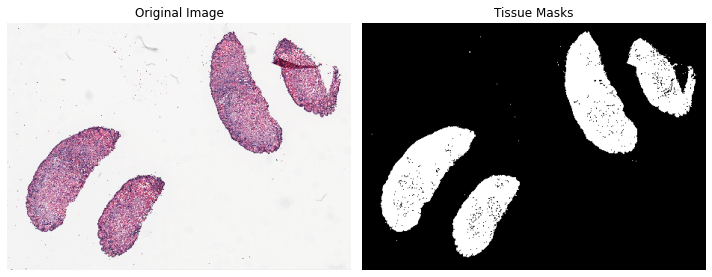

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

axes[0].imshow(data.image[::100, ::100])
axes[0].set_title("Original Image")

axes[1].imshow(data.mask[::100, ::100], cmap = plt.cm.gray)
axes[1].set_title("Tissue Masks")

axes[0].axis('off'); axes[1].axis('off')
fig.tight_layout()
plt.show()

We can see that the tissue detection worked reasonably well with the default parameters. It's ok that it didn't work perfectly, because when we move to the next step (tile extraction) we are only looking at the mean of the mask region corresponding to the tile. So this should be robust to a handful of misclassified pixels. 

## Define Tile Extractor

The next step is to divide the whole-slide image into tiles. The raw WSI is too large to process all at once, so we divide into smaller tiles that are more manageable in size (e.g. 224px). For each tile, we look at the corresponding region in the mask created from tissue detection, and only keep the tiles that have ≥50% tissue pixels. The default `SimpleTileExtractor` will work for this - but if we needed more complex tile extraction logic, we would simply create a new class inheriting from `BaseTileExtractor` and define the `apply()` method as above. See the `Advanced H&E Workflow` example notebook for more details.

In [8]:
data = SimpleTileExtractor(tile_size=224).apply(data)

Let's plot where the tiles were extracted from on the original image:

Let's take a look at a few random tiles:

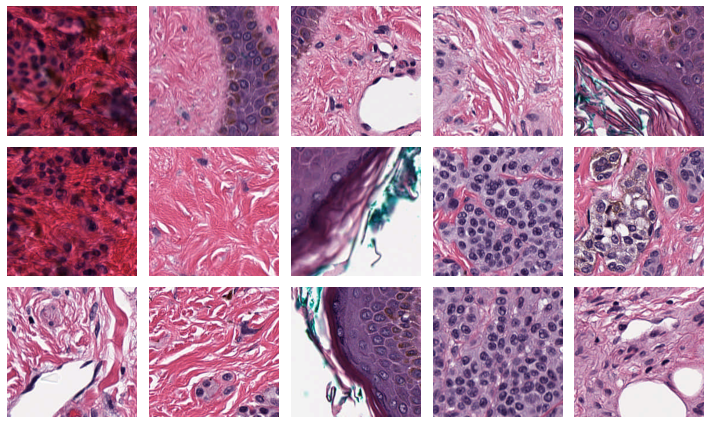

In [9]:
nrow = 3; ncol = 5
random_tiles = random.choices(data.tiles, k=nrow*ncol)

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 6))

for ax, tile in zip(axes.ravel(), random_tiles):
    ax.imshow(tile.array)
    ax.axis('off')

fig.tight_layout()
plt.show()

## Define Custom Tile Preprocessor

The final step in the pipeline is to apply tile-level preprocessing. For this example, we will apply a color normalization based on the Macenko stain deconvolution method. We will also apply a simple threshold-based method to filter out any whitespace tiles that may have been extracted.

In [10]:
class MyTilePreprocessor(BaseTilePreprocessor):
    """
    Simple tile preprocessor which applies color normalizations, 
    filters out whitespace tiles, and writes tiles to disk
    """
    def apply(self, data):
        normalizer = StainNormalizationHE(stain_estimation_method='macenko')
        # save the processed tiles to a new directory in same location as original wsi
        out_dir = os.path.join(
            os.path.dirname(data.wsi.path), 
            os.path.splitext(os.path.basename(data.wsi.path))[0] + "_tiled"
        )
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        # extra step to filter out whitespace tiles
        data.tiles[:] = [tile for tile in data.tiles if not label_whitespace_HE(tile.array)]
        # now loop through tiles, normalize the color, and save to disk
        for tile in data.tiles:            
            tile.array = normalizer.apply(tile.array)
            tile.save(out_dir = out_dir, filename = f"{data.wsi.name}_{tile.i}_{tile.j}.jpeg")
        return data

In [11]:
data = MyTilePreprocessor().apply(data)

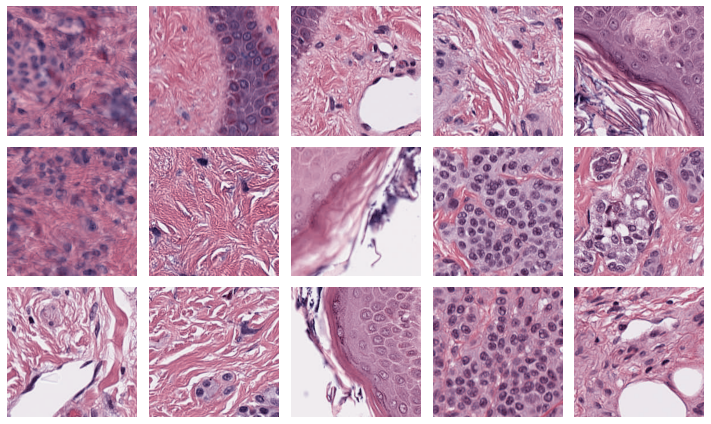

In [12]:
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 6))

for ax, tile in zip(axes.ravel(), random_tiles):
    ax.imshow(tile.array)
    ax.axis('off')

fig.tight_layout()
plt.show()

## Putting it all together: defining a `Pipeline`

In [13]:
my_pipeline = Pipeline(
    slide_loader       = MySlideLoader(),
    slide_preprocessor = MySlidePreprocessor(),
    tile_extractor     = SimpleTileExtractor(tile_size=224),
    tile_preprocessor  = MyTilePreprocessor()
)

Now that we have built our `Pipeline` we are ready to run it on a new image with just a single call:

In [14]:
%%time
my_pipeline.run("../data/CMU-2.svs")

CPU times: user 18min 29s, sys: 3min 2s, total: 21min 31s
Wall time: 10min 24s


SlideData(wsi=HESlide(path=../data/CMU-2.svs, name=CMU-2), image shape: (30462, 78000, 3), mask shape: (30462, 78000), number of tiles: 11302)